In [23]:
from typing import Annotated
import os
from IPython.display import Image, display
from typing_extensions import TypedDict

from langchain_tavily import TavilySearch
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver



from dotenv import load_dotenv
load_dotenv()

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "cathay-agent-club"
model_name = 'bedrock_converse:anthropic.claude-3-5-sonnet-20240620-v1:0'

In [24]:
tool = TavilySearch(max_results=2)
tools = [tool]

In [25]:
llm = init_chat_model(model=model_name)
llm_with_tool = llm.bind_tools([tool])

In [26]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [27]:
def chatbot(state: State):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

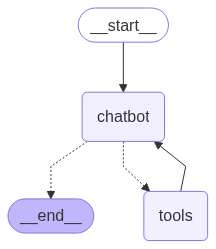

In [28]:
graph_builder = StateGraph(state_schema=State)
tool_node = ToolNode(tools)
memory = InMemorySaver()

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
user_input = "台灣現在跟美國的關稅是多少"
config = {"configurable": {"thread_id": "1"}}


for chunk in graph.stream(State(messages=[user_input]), stream_mode="updates", config=config):
    print(chunk)
    print("\n")

{'chatbot': {'messages': [AIMessage(content=[{'type': 'text', 'text': '为了回答您关于台湾和美国之间现行关税的问题，我需要搜索最新的相关信息。让我为您查找一下。'}, {'type': 'tool_use', 'name': 'tavily_search', 'input': {'query': '台湾和美国之间的现行关税率', 'search_depth': 'advanced'}, 'id': 'tooluse_NAtRyEbGQ7CeOYF3UDftyQ'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'afeb83ae-57a8-4ea6-821c-84cd0942b0e0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 01 Aug 2025 17:26:37 GMT', 'content-type': 'application/json', 'content-length': '487', 'connection': 'keep-alive', 'x-amzn-requestid': 'afeb83ae-57a8-4ea6-821c-84cd0942b0e0'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [2750]}, 'model_name': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run--8f1b333a-ddbc-4bbd-8c0e-c67e14b14c94-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': '台湾和美国之间的现行关税率', 'search_depth': 'advanced'}, 'id': 'tooluse_NAtRyEbGQ7CeOYF3UDftyQ', 'type': 'tool_call'}], usage_metadata={'input_toke

In [ ]:
user_input = "簡短說明你對現況的看法"


for chunk in graph.stream(State(messages=[user_input]), stream_mode="updates", config=config):
    print(chunk)
    print("\n")

KeyError: 'messages'